# Data Stream Processing - Project 3 : Ideas for Extension (20%)

In [2]:
# Import librairies.
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby


## The data

In [3]:
# Get files
DATAPATH =  "../data/custom_no_streaming_8/folder_2"
files = glob.glob(rf"{DATAPATH}/*")
files

['../data/custom_no_streaming_8/folder_2\\1_3.csv',
 '../data/custom_no_streaming_8/folder_2\\1_4.csv',
 '../data/custom_no_streaming_8/folder_2\\2_3.csv',
 '../data/custom_no_streaming_8/folder_2\\2_4.csv',
 '../data/custom_no_streaming_8/folder_2\\3_3.csv',
 '../data/custom_no_streaming_8/folder_2\\3_4.csv']

In [8]:
# Read anomaly files and concatenate dataframes
dfs = []
for file in files[:-1]:
    df = pd.read_csv(file)
    # Extract the filename without the parent folder path and extension
    filename = file.split('\\')[-1].split('.')[0]
    # Add a new column "anomaly_type" with the extracted filename
    df.insert(1, column="trace_id", value=filename)
    df.rename({"Unnamed: 0": "time"}, axis=1, inplace=True)
    dfs.append(df)

# Concatenate all dataframes except labels.csv
anomaly_df = pd.concat(dfs)
anomaly_df

# Rename values in the "anomaly_type" column based on the specified mapping
mapping = {
    "1_3": "bursty_input",
    "1_4": "bursty_input",
    "2_3": "stalled_input",
    "2_4": "stalled_input",
    "3_3": "cpu_contention",
    "3_4": "cpu_contention"
}
anomaly_df.insert(2, column="anomaly_type", value=anomaly_df['trace_id'].replace(mapping))

anomaly_df

,time,trace_id,anomaly_type,driver_BlockManager_memory_memUsed_MB_value,driver_jvm_heap_used_value,avg_jvm_heap_used_value,avg_executor_filesystem_hdfs_write_ops_value_1_diff,avg_executor_cpuTime_count_1_diff,avg_executor_runTime_count_1_diff,avg_executor_shuffleRecordsRead_count_1_diff,avg_executor_shuffleRecordsWritten_count_1_diff
0,0,1_3,bursty_input,505.0,802632640.0,2.948889e+09,0.0,0.0,0.0,0.0,0.0
1,1,1_3,bursty_input,520.0,811308500.0,2.972305e+09,0.0,0.0,0.0,0.0,0.0
2,2,1_3,bursty_input,536.0,792553660.0,2.652633e+09,0.0,355610140.0,373.0,0.0,9981.0
3,3,1_3,bursty_input,482.0,779442200.0,2.686896e+09,0.0,0.0,0.0,0.0,0.0
4,4,1_3,bursty_input,497.0,789423170.0,2.706626e+09,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
21759,21759,3_3,cpu_contention,10447.0,522127260.0,7.867158e+09,12.0,398201800.0,656.0,27356.5,4216.5
21760,21760,3_3,cpu_contention,8684.0,554331460.0,8.139178e+09,0.0,0.0,0.0,0.0,0.0
21761,21761,3_3,cpu_contention,8882.0,566017860.0,8.361957e+09,0.0,0.0,0.0,0.0,0.0
21762,21762,3_3,cpu_contention,9088.0,573878800.0,8.542828e+09,0.0,0.0,0.0,0.0,0.0


In [29]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Charger les données
# Assurez-vous que votre fichier CSV est correctement formaté et accessible
df = anomaly_df[anomaly_df['trace_id'] == '1_3'].copy()

# Sélectionner les colonnes numériques pertinentes (exclure 'time' et 'trace_id')
cols = df.columns[3:]

# Normaliser les données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[cols])

# Reshape data pour LSTM [samples, time steps, features]
timesteps = 1  # Vous pouvez ajuster cela selon votre séquence de temps
features = len(cols)
data = df_scaled.reshape(df_scaled.shape[0], timesteps, features)

# Construction de l'autoencodeur LSTM
inputs = Input(shape=(timesteps, features))
encoded = LSTM(10, return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(features, return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraîner le modèle
autoencoder.fit(data, data, epochs=20, batch_size=128, validation_split=0.2, shuffle=True)

# Prédire les données reconstruites
predictions = autoencoder.predict(data)

# Calculer l'erreur de reconstruction
mse = np.mean(np.power(data - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse[:,0]})

# Identifier les anomalies (Vous pouvez définir un seuil d'erreur)
threshold = np.percentile(error_df.Reconstruction_error.values, 95)
anomalies = error_df[error_df.Reconstruction_error > threshold]

# calculer le pourcentage d'anomalies
anomaly_ratio = 100*anomalies.shape[0] / error_df.shape[0]
print('Pourcentage d\'anomalies: ', anomaly_ratio)

Epoch 1/20
162/162 [==============================] - 4s 7ms/step - loss: 0.6955 - val_loss: 1.9304
Epoch 2/20
162/162 [==============================] - 1s 5ms/step - loss: 0.5501 - val_loss: 1.8675
Epoch 3/20
162/162 [==============================] - 1s 4ms/step - loss: 0.4641 - val_loss: 1.8116
Epoch 4/20
162/162 [==============================] - 1s 5ms/step - loss: 0.4130 - val_loss: 1.7770
Epoch 5/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3839 - val_loss: 1.7581
Epoch 6/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3661 - val_loss: 1.7477
Epoch 7/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3545 - val_loss: 1.7423
Epoch 8/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3466 - val_loss: 1.7424
Epoch 9/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3414 - val_loss: 1.7407
Epoch 10/20
162/162 [==============================] - 1s 4ms/step - loss: 0.3382 - val_loss: 1.7396

In [26]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler

# Charger les données
df = anomaly_df[anomaly_df['trace_id'] == '1_4'].copy()

# Sélectionner les colonnes numériques pertinentes (exclure 'time' et 'trace_id')
cols = df.columns[3:]

# Normaliser les données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[cols])

# Paramètres du VAE
input_shape = df_scaled.shape[1]
intermediate_dim = 5
latent_dim = 2

# Encoder
inputs = Input(shape=(input_shape,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(input_shape, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Instancier le VAE
vae = Model(inputs, x_decoded_mean)

# Calcule de la perte du VAE
xent_loss = mse(inputs, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Entraîner le VAE
vae.fit(df_scaled, epochs=20, batch_size=32, validation_split=0.2)

# Utiliser le VAE pour la détection d'anomalies
predictions = vae.predict(df_scaled)
mse = np.mean(np.power(df_scaled - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})

# Définir un seuil pour identifier les anomalies
threshold = np.percentile(error_df.Reconstruction_error.values, 95)
anomalies = error_df[error_df.Reconstruction_error > threshold]

# calculer le pourcentage d'anomalies
anomaly_ratio = 100* anomalies.shape[0] / error_df.shape[0]
print('Pourcentage d\'anomalies: ', anomaly_ratio)

Epoch 1/20
533/533 [==============================] - 2s 3ms/step - loss: 1.6156 - val_loss: 0.7888
Epoch 2/20
533/533 [==============================] - 1s 2ms/step - loss: 1.1530 - val_loss: 0.6577
Epoch 3/20
533/533 [==============================] - 1s 2ms/step - loss: 1.1164 - val_loss: 0.6287
Epoch 4/20
533/533 [==============================] - 1s 2ms/step - loss: 1.1089 - val_loss: 0.6213
Epoch 5/20
533/533 [==============================] - 1s 2ms/step - loss: 1.1067 - val_loss: 0.6201
Epoch 6/20
533/533 [==============================] - 1s 2ms/step - loss: 1.1032 - val_loss: 0.6166
Epoch 7/20
533/533 [==============================] - 1s 2ms/step - loss: 1.1028 - val_loss: 0.6168
Epoch 8/20
533/533 [==============================] - 1s 2ms/step - loss: 1.1020 - val_loss: 0.6165
Epoch 9/20
533/533 [==============================] - 1s 2ms/step - loss: 1.1017 - val_loss: 0.6149
Epoch 10/20
533/533 [==============================] - 1s 2ms/step - loss: 1.1029 - val_loss: 0.6131

In [36]:
df

,time,trace_id,anomaly_type,driver_BlockManager_memory_memUsed_MB_value,driver_jvm_heap_used_value,avg_jvm_heap_used_value,avg_executor_filesystem_hdfs_write_ops_value_1_diff,avg_executor_cpuTime_count_1_diff,avg_executor_runTime_count_1_diff,avg_executor_shuffleRecordsRead_count_1_diff,avg_executor_shuffleRecordsWritten_count_1_diff
0,0,1_3,bursty_input,505.0,8.026326e+08,2.948889e+09,0.0,0.0,0.0,0.0,0.0
1,1,1_3,bursty_input,520.0,8.113085e+08,2.972305e+09,0.0,0.0,0.0,0.0,0.0
2,2,1_3,bursty_input,536.0,7.925537e+08,2.652633e+09,0.0,355610140.0,373.0,0.0,9981.0
3,3,1_3,bursty_input,482.0,7.794422e+08,2.686896e+09,0.0,0.0,0.0,0.0,0.0
4,4,1_3,bursty_input,497.0,7.894232e+08,2.706626e+09,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
25782,25782,1_3,bursty_input,528.0,1.426292e+09,3.564818e+09,0.0,400807870.0,420.0,0.0,20430.5
25783,25783,1_3,bursty_input,474.0,1.454796e+09,3.591368e+09,0.0,0.0,0.0,0.0,0.0
25784,25784,1_3,bursty_input,489.0,1.464625e+09,3.619395e+09,0.0,0.0,0.0,0.0,0.0
25785,25785,1_3,bursty_input,497.0,1.473931e+09,3.648677e+09,0.0,0.0,0.0,0.0,0.0


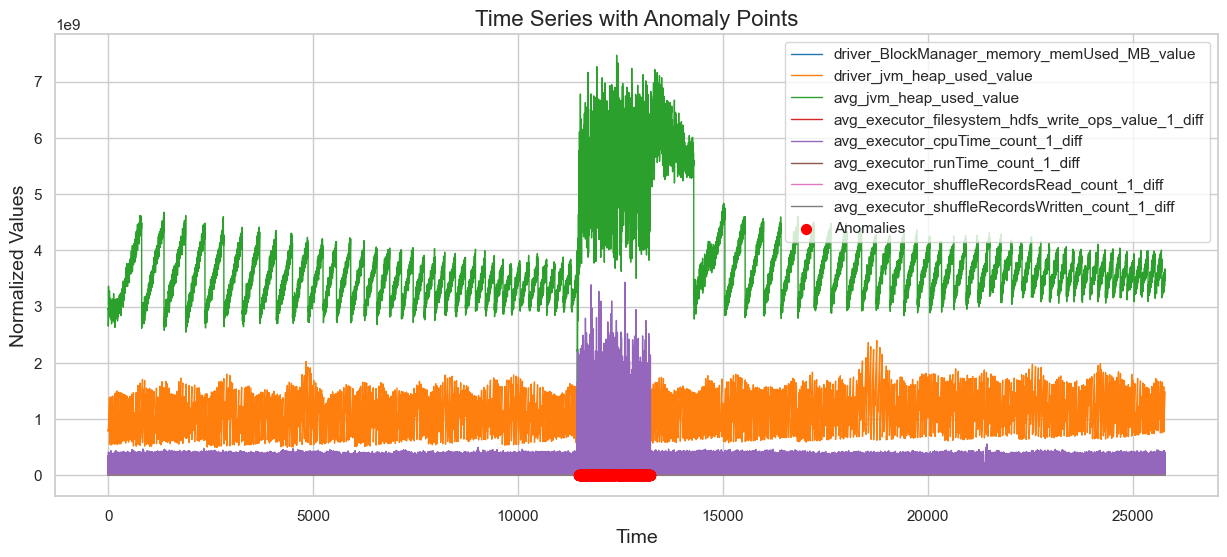

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn style for better aesthetics
sns.set(style='whitegrid')

# Define color palette for the time series
colors = sns.color_palette('tab10', len(cols))

# Create a figure and axis for the plot
plt.figure(figsize=(15, 6))
ax = plt.gca()

# Plot each time series with a thinner line
for i, col in enumerate(cols):
    ax.plot(df['time'], df[col], color=colors[i], linewidth=1, label=col)

# Highlight anomaly points with red color
ax.scatter(anomalies['time'], df.loc[anomalies.index, cols[0]], color='red', s=50, label='Anomalies', zorder=5)

# Set title and labels with appropriate font sizes
ax.set_title('Time Series with Anomaly Points', fontsize=16)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Normalized Values', fontsize=14)

# Place the legend in the upper right corner of the plot
ax.legend(loc='upper right', frameon=True)

# Display the plot
plt.show()
